In [1]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.table import Table

import sys
sys.path.append('../')
from source_names_dict import source_names_dict, source_names_readable, get_simbad_name_glob

In [2]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [3]:
tab = Table.read('../lightcurves/uvot/[BBL2003b]_IC_342_X-2,UVOT_U.fits')
df  = pd.read_csv('../lightcurves/xrt/NAME_NGC_1313_X-1,curve_nosys_join.csv', dtype={'obsID':'str'})              

gapsize=120.00 days
group 0 (54427.7994798415--54439.5280985854) 2
group 1 (55064.1156150141--55185.105637274) 29
group 2 (56210.6216599709--56283.8870893253) 4
group 3 (56453.8854115579--59500.6427092952) 468
group 4 (59648.2326862859--59676.3777337327) 5


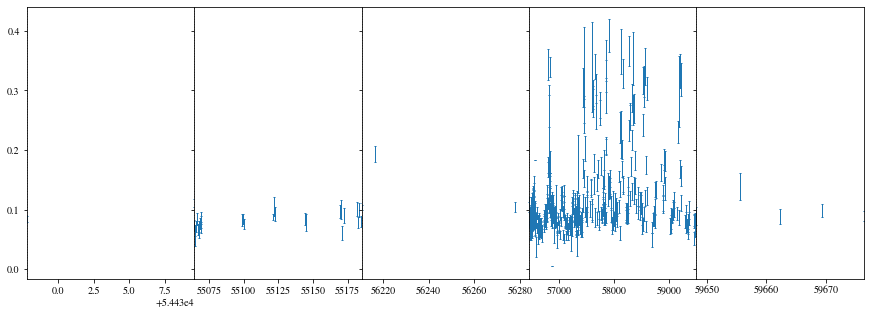

In [4]:
df['MJD_delta']  = df['MJD'].diff()              # diff from previous time
gapsize = 120
#gapsize = 0.01 * (df['MJD'].max() - df['MJD'].min())

df['gap']        = df['MJD_delta'].gt(gapsize)
df['group']      = df['gap'].cumsum()
groups = df.groupby('group')


minvals = 1
nvals = np.array([len(g) for i, g in groups])
n_groups_g_1 = len(nvals[nvals > 1])


xticks = np.linspace(df['MJD'].min(), df['MJD'].max(), 100)



f, ax = plt.subplots(ncols=n_groups_g_1, sharey=True, figsize=(15,5), facecolor='white')



print(f'gapsize={gapsize:.2f} days')
i = 0
for idx, g in groups:
    if len(g)>1:
        start = g['MJD'].iloc[0]
        stop = g['MJD'].iloc[-1]

        ax[i].errorbar(g['MJD'], g['Rate'], yerr=(g['Rateneg'].abs(), g['Ratepos']), ls='none', lw=1.0, capsize=1.0)

        #ax[i].set_xticks(xticks)
        #ax[i].set_xticklabels([])
        ax[i].set_xlim(start,stop)

        if (i > 0):
            pass
            #ax[i].spines['left'].set_visible(False)
            #ax[i].spines['right'].set_visible(False)
            #ax[i].yaxis.tick_left()
            #ax[i].yaxis.tick_right()


        ax[i].axvline(start, color='grey', ls='dotted', lw=1.0)
        ax[i].axvline(stop, color='blue', ls='dotted', lw=1.0)
        
        print(f'group {i} ({start}--{stop}) {len(g)}')
        i+=1


plt.subplots_adjust(wspace=0)

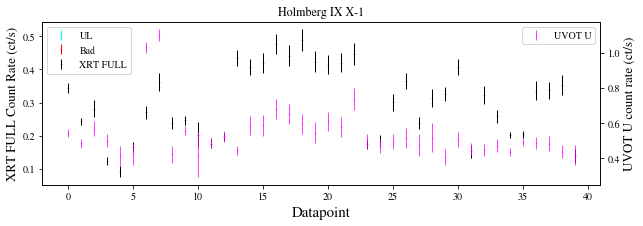

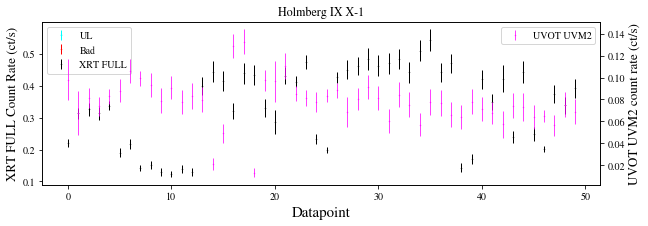

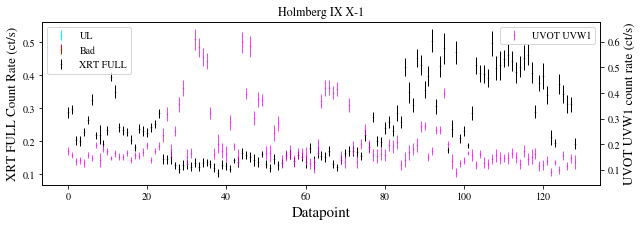

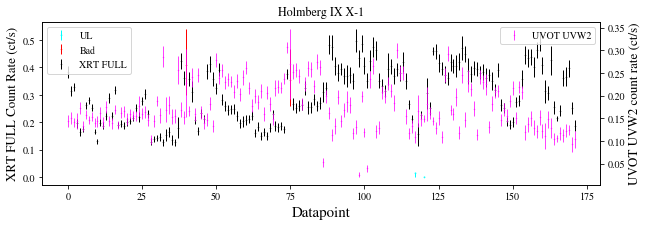

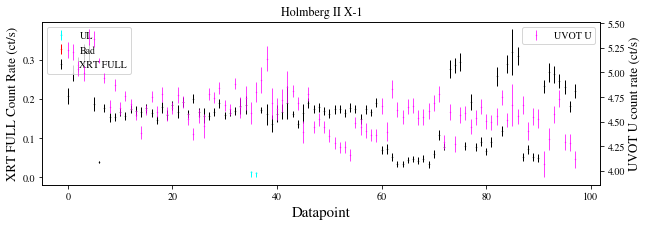

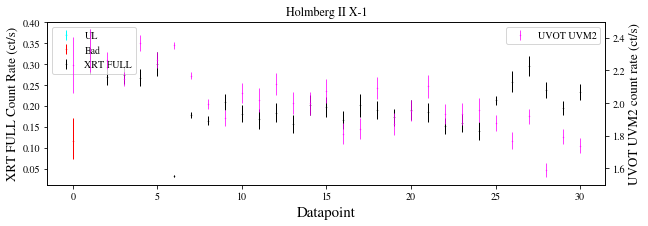

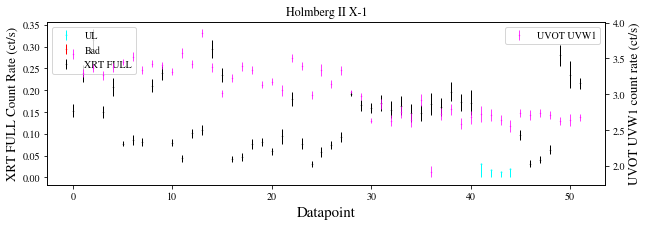

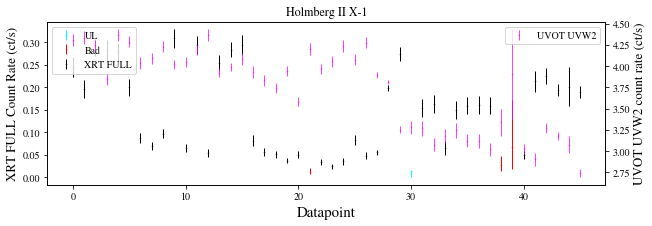

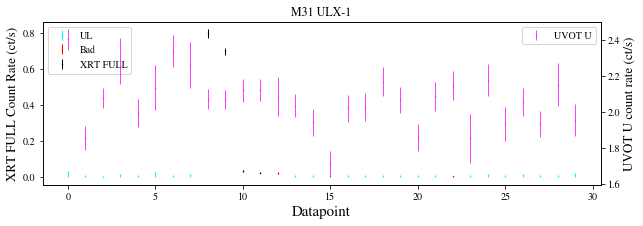

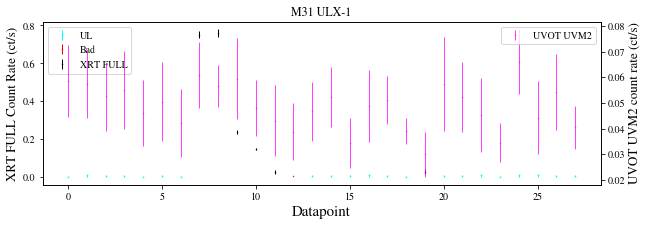

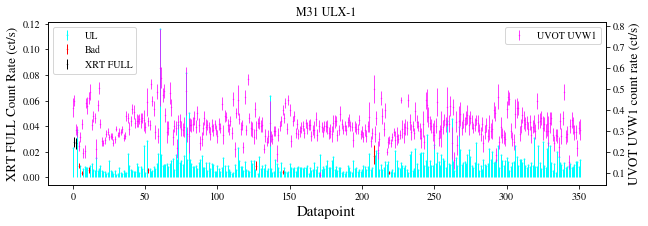

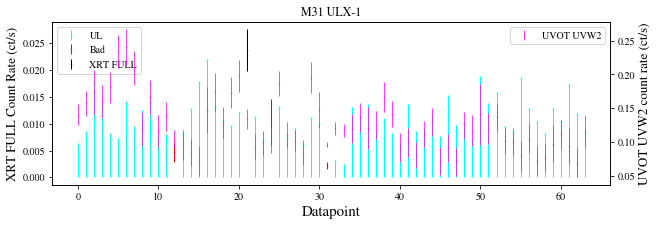

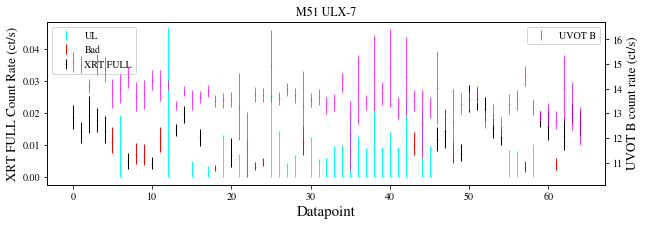

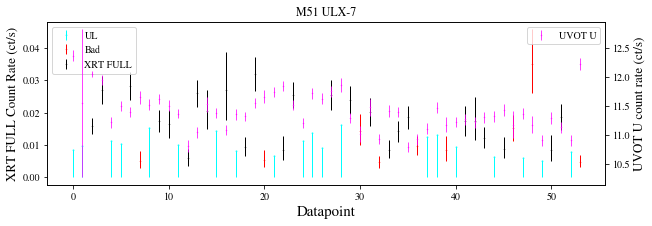

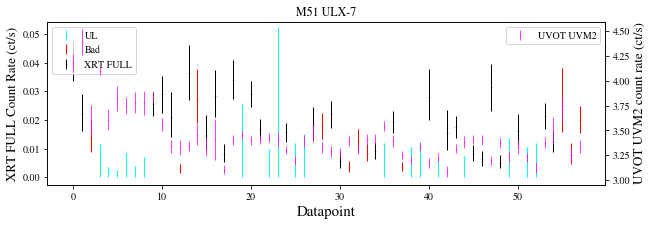

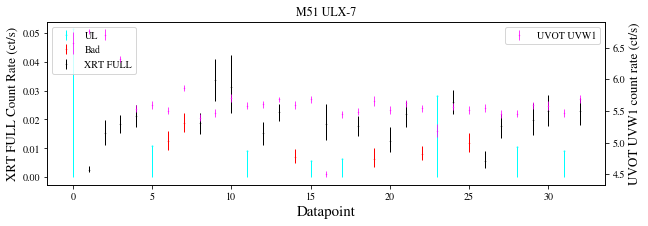

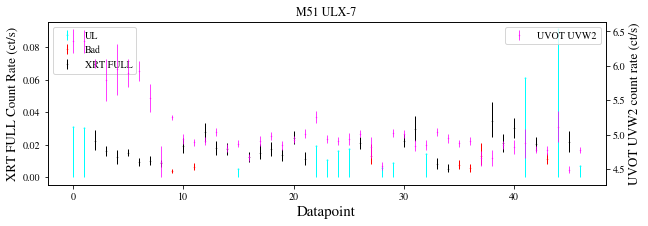

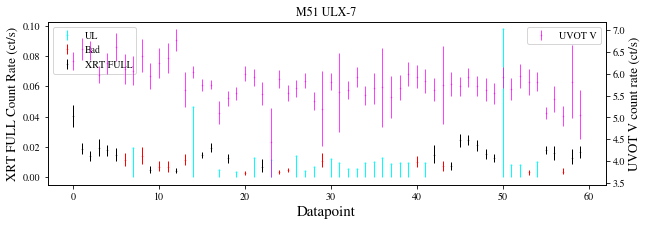

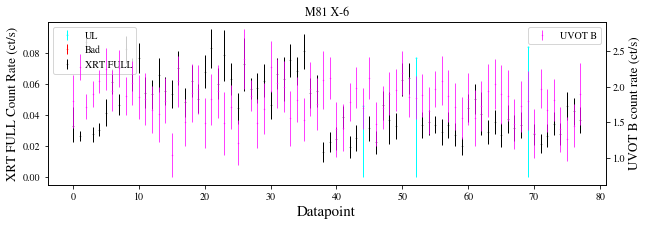

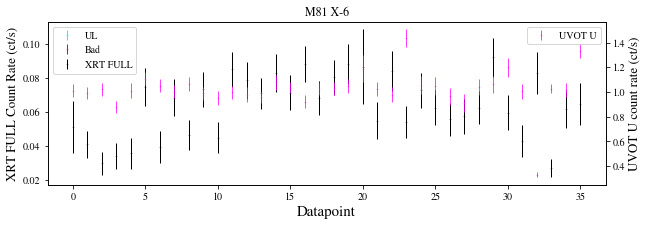

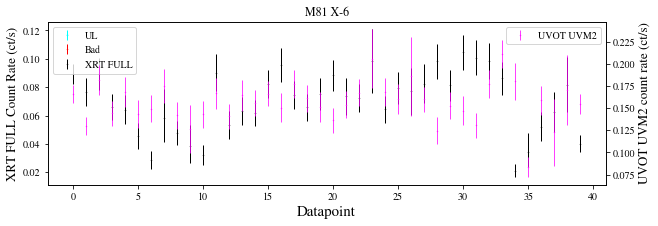

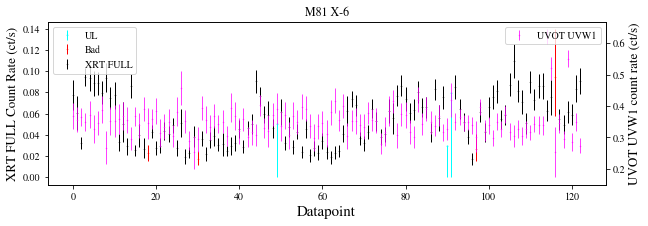

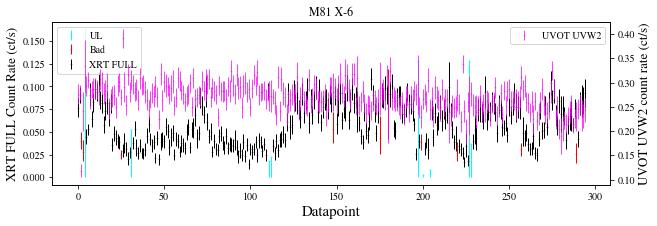

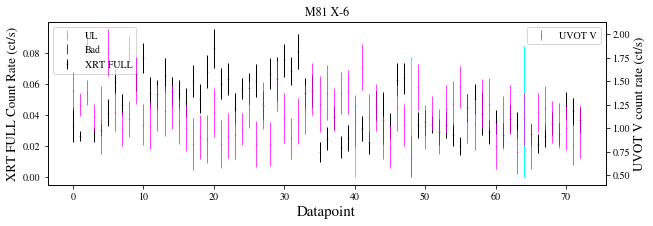

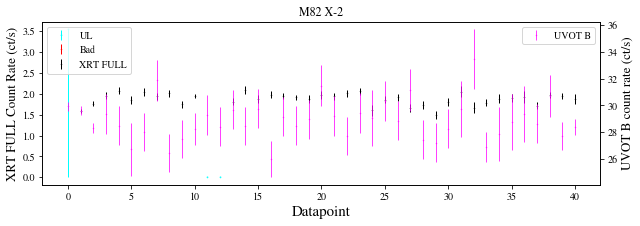

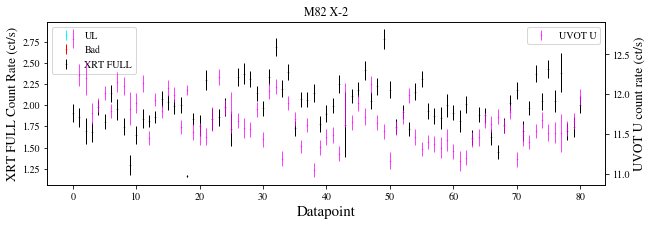

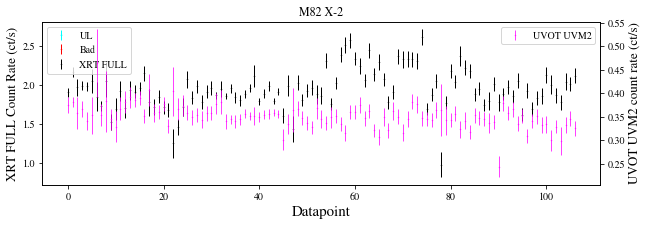

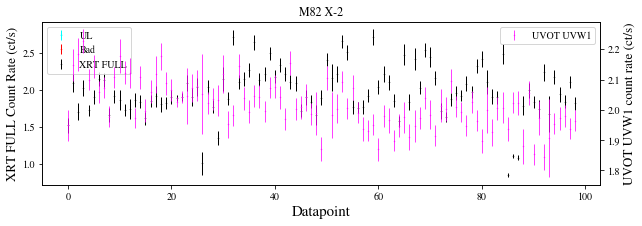

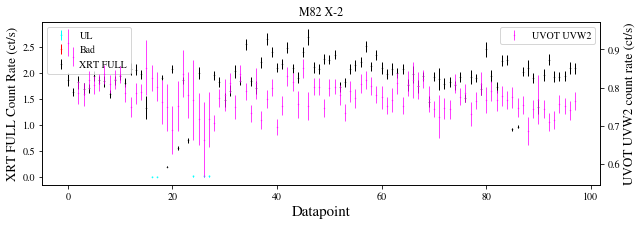

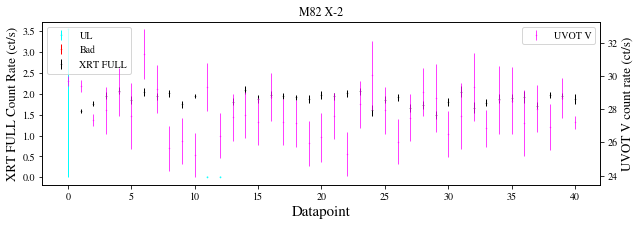

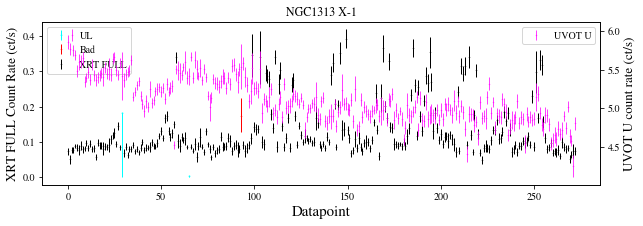

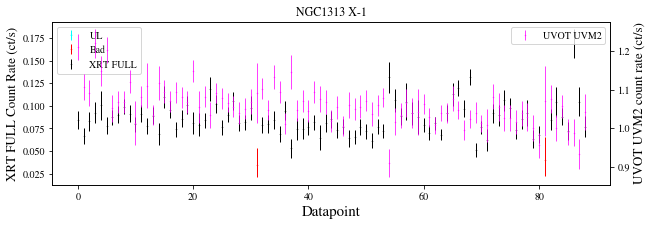

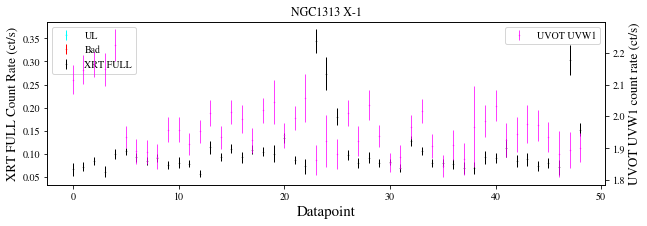

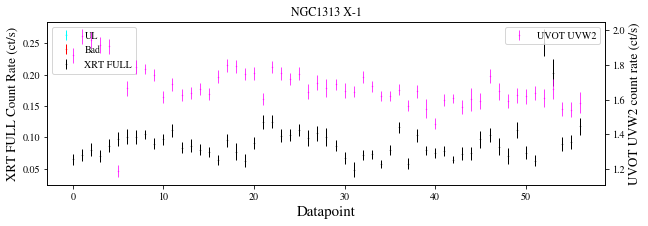

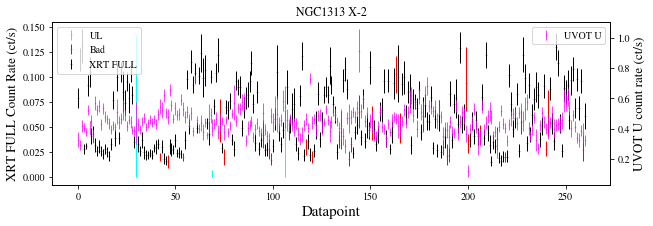

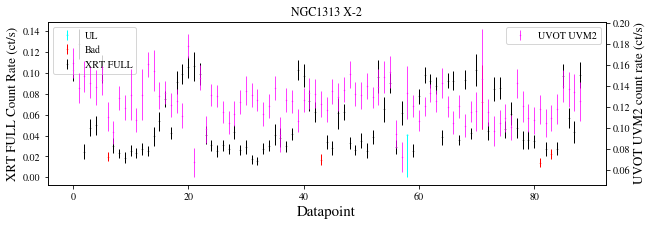

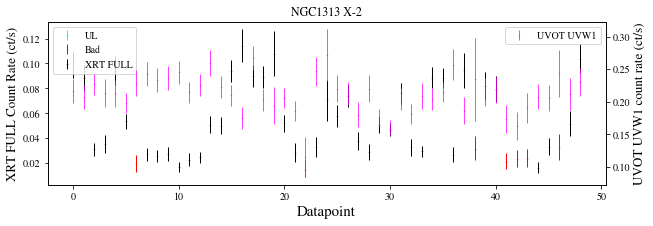

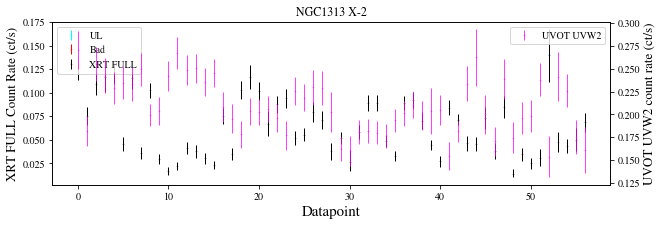

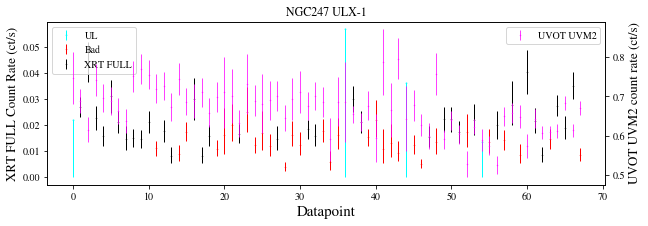

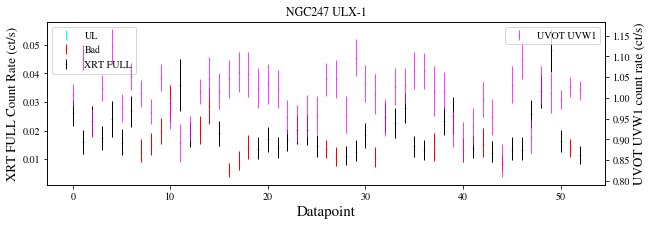

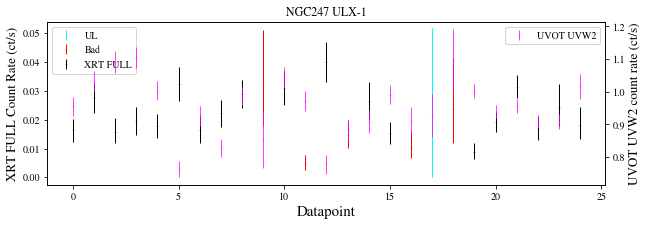

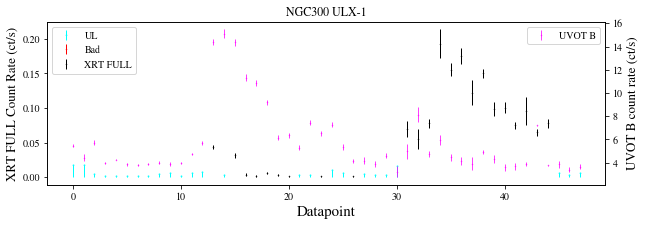

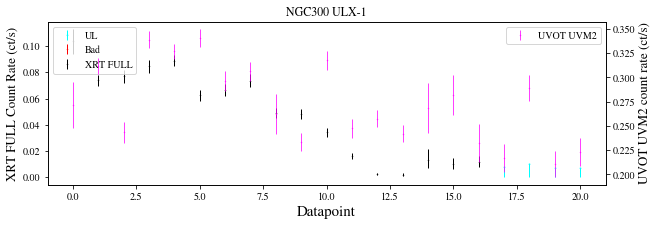

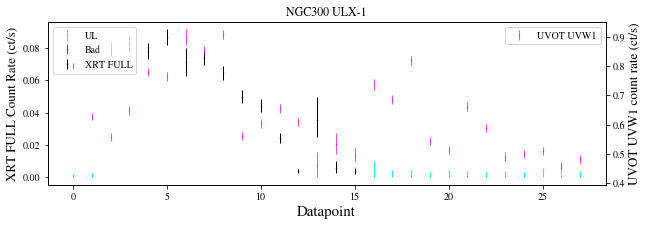

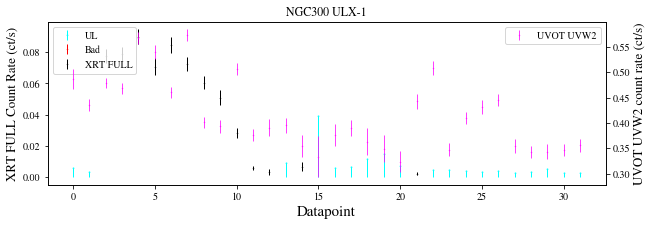

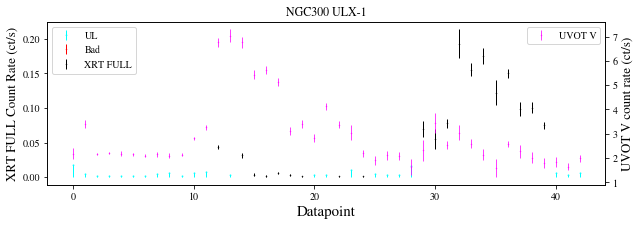

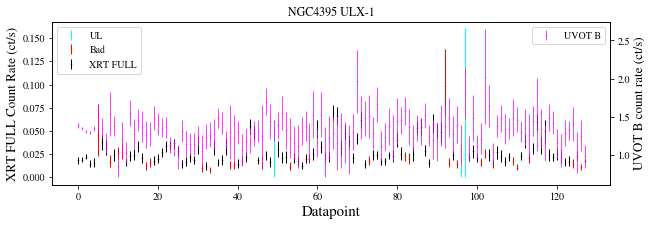

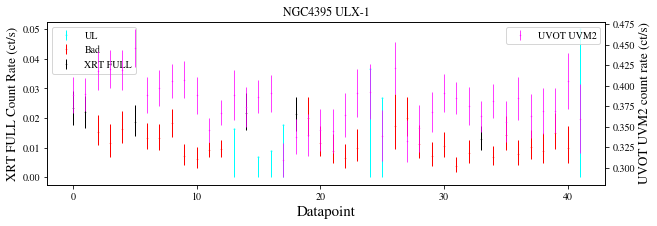

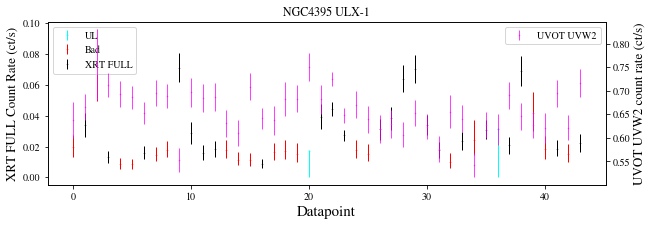

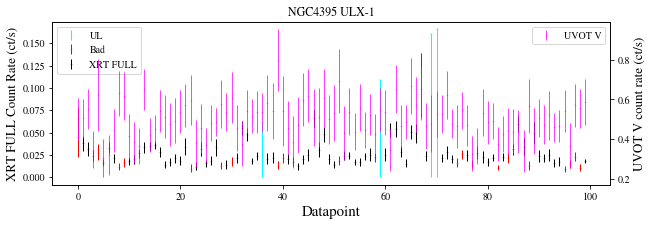

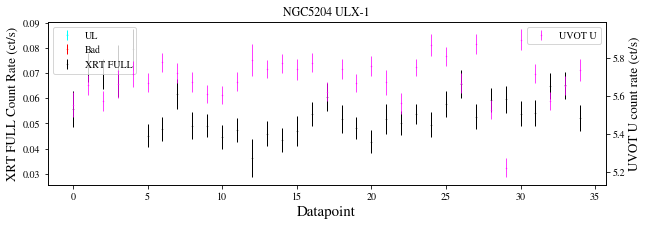

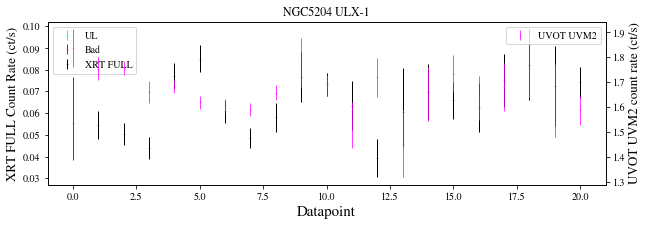

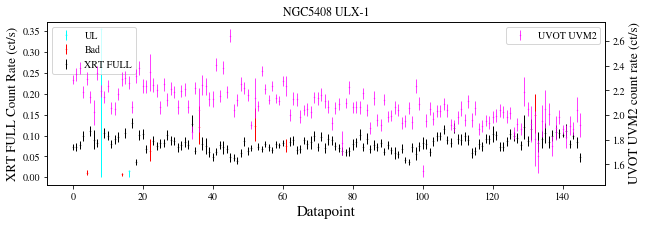

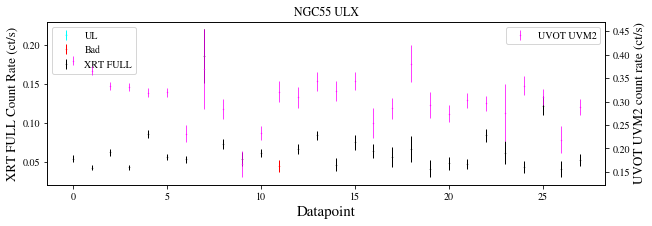

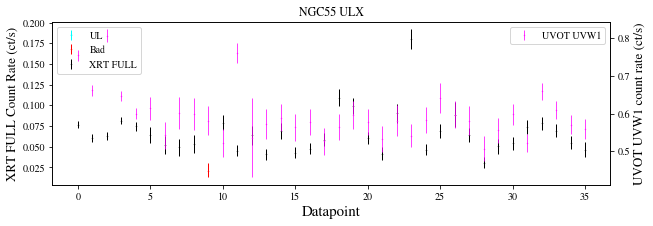

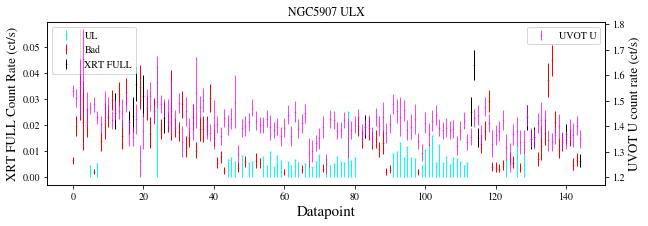

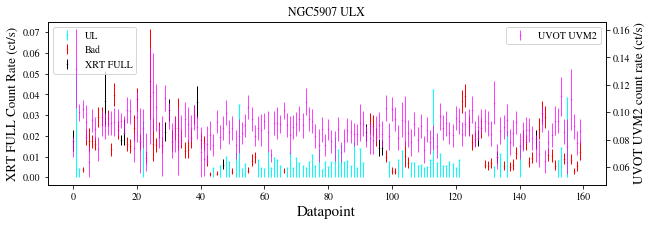

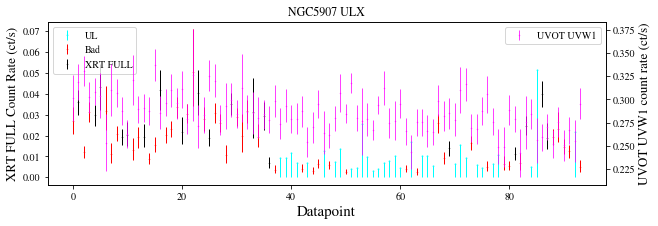

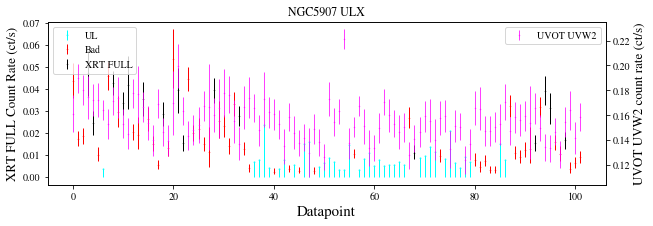

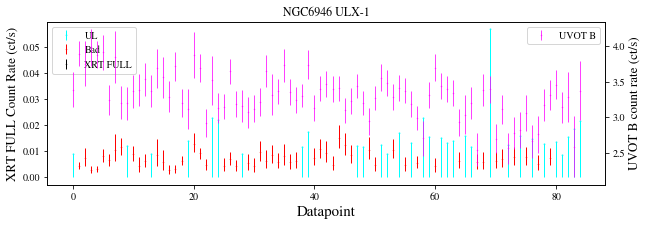

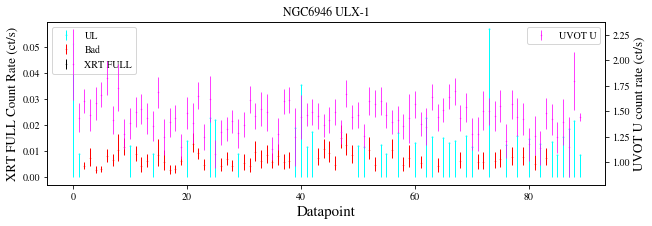

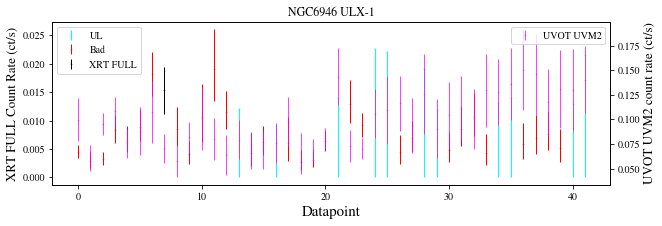

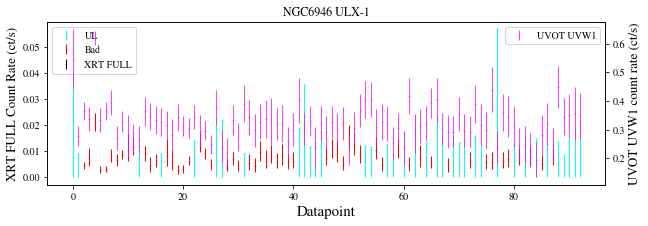

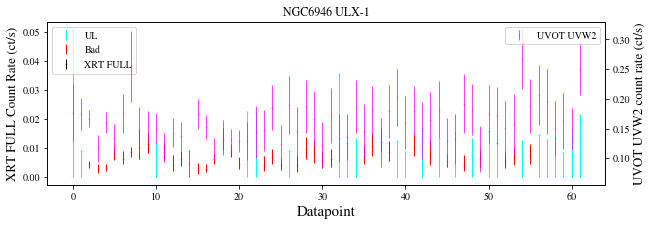

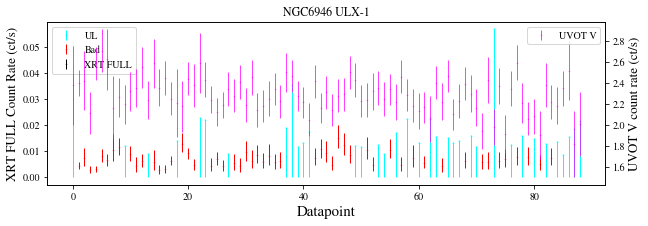

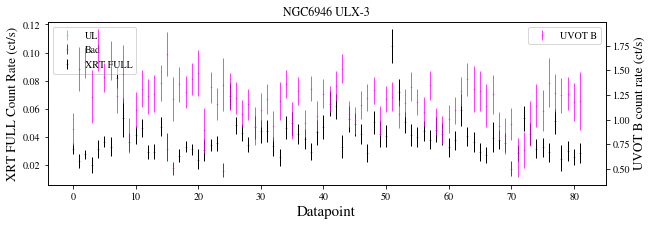

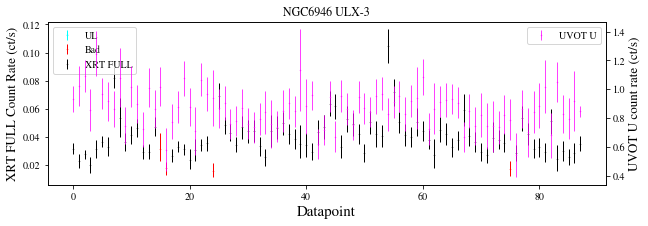

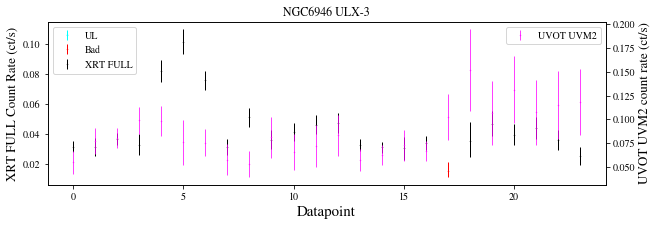

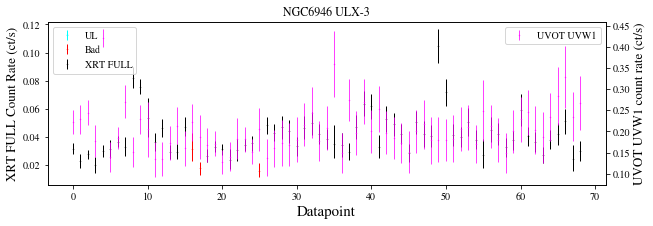

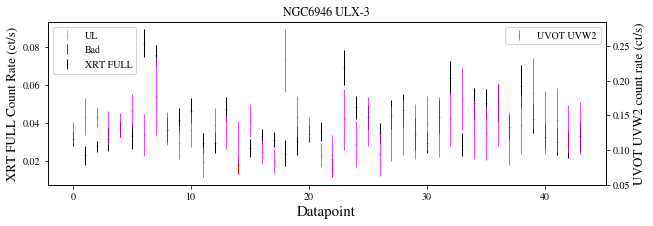

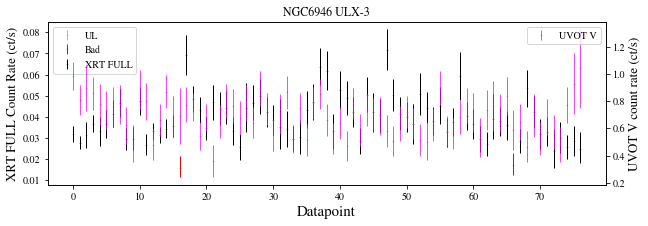

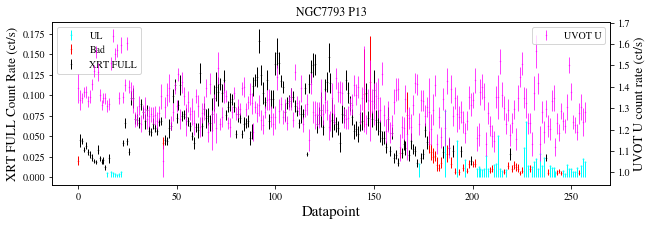

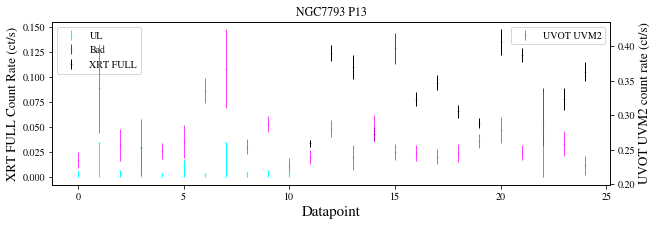

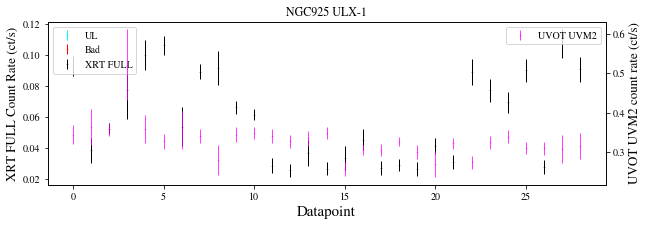

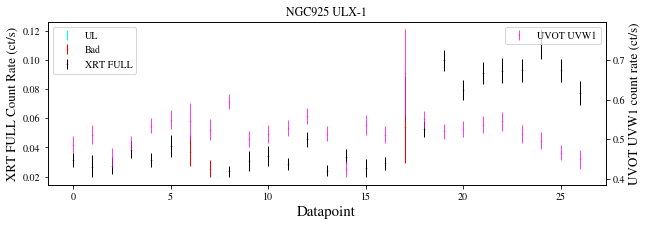

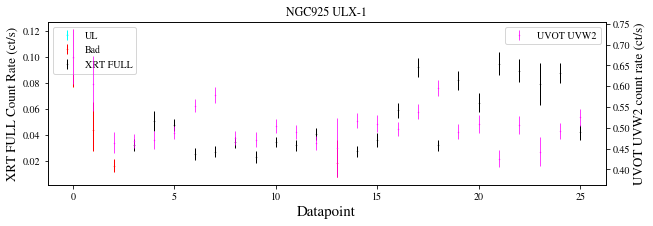

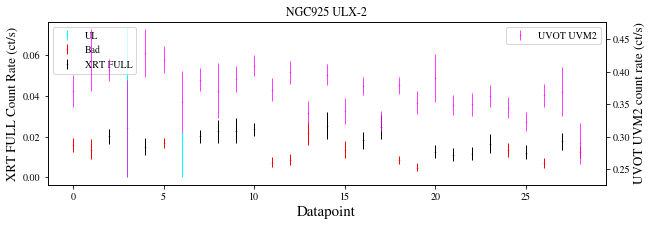

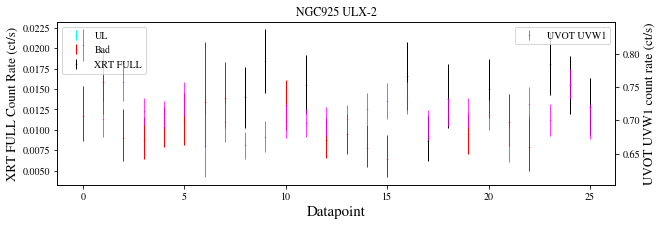

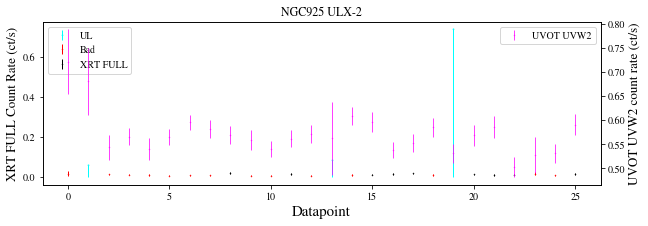

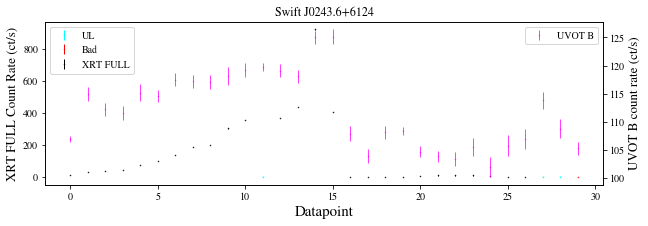

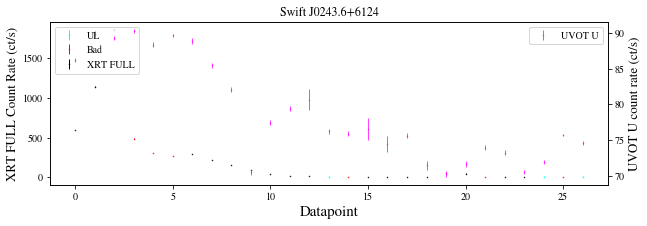

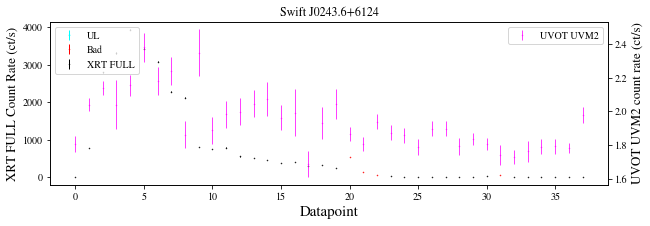

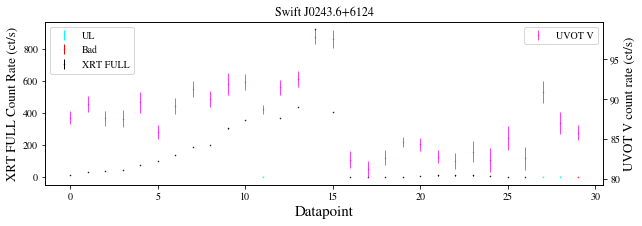

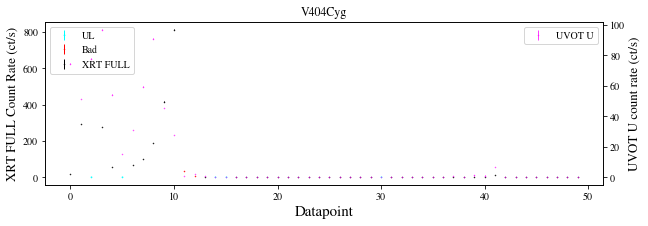

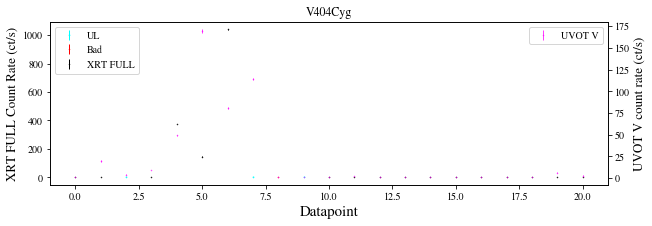

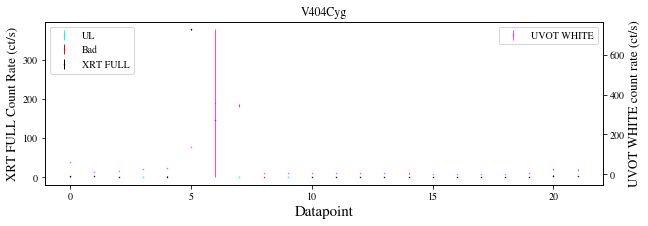

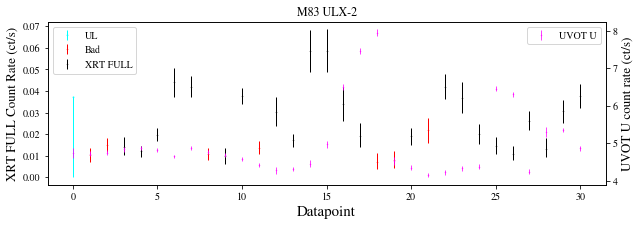

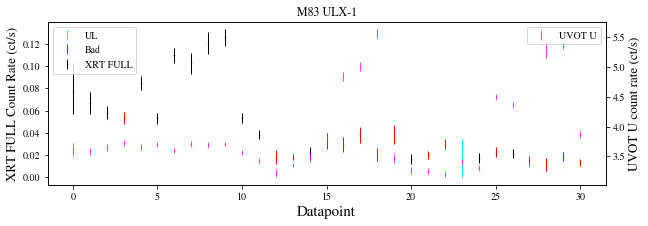

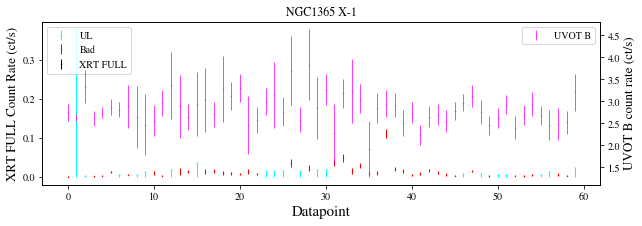

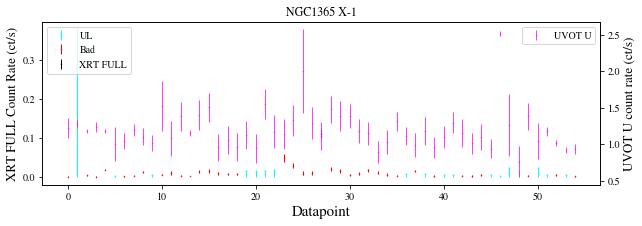

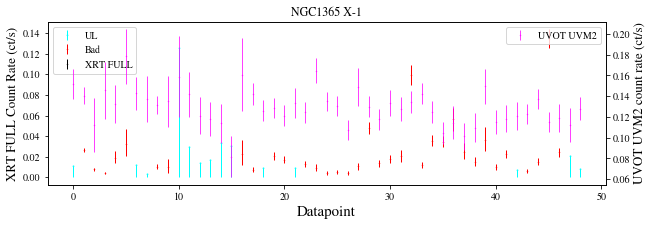

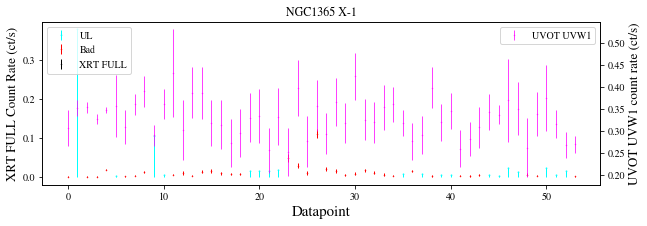

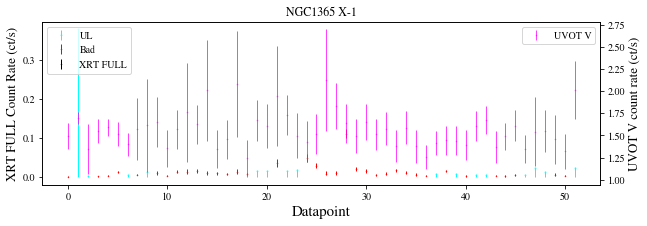

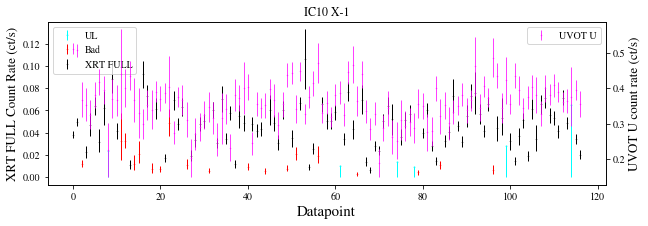

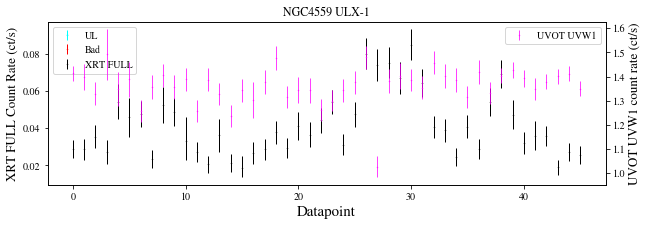

In [5]:
uvot_rate     = 'COI_SRC_RATE'
uvot_rate_err = 'COI_SRC_RATE_ERR'
xrt_rate      = 'Rate'
xrt_rate_err  = 'Ratepos'
for simbad_name, local_name in source_names_dict.items():
    simbad_name_glob = get_simbad_name_glob(simbad_name)
    readable_name = source_names_readable[simbad_name]
    for fn in glob(f'../lightcurves/joined/*{simbad_name_glob}*curve_nosys_join*'):
        
        fn_short = fn.split('/')[-1][:-5]
        simbad_name = fn.split('/')[-1][:-5].split(',')[0]
        uvot_filter = fn.split('/')[-1][:-5].split(',')[1]
        xrt_curve   = fn.split('/')[-1][:-5].split(',')[2]

        tab = Table.read(fn)

        xrt_band = np.unique(tab['BAND'])[0]

        xrt_rate_mean  = np.mean(tab[xrt_rate])
        uvot_rate_mean = np.mean(tab[uvot_rate])

        xrt_rate_std  = np.std(tab[xrt_rate])
        uvot_rate_std = np.std(tab[uvot_rate])

        tab = tab[(tab[xrt_rate] < xrt_rate_mean + 5 * xrt_rate_std)
                & (tab[xrt_rate] > xrt_rate_mean - 5 * xrt_rate_std)
                & (tab[uvot_rate] < uvot_rate_mean + 5 * uvot_rate_std)
                & (tab[uvot_rate] > uvot_rate_mean - 5 * uvot_rate_std)]

        tab['idx'] = np.arange(len(tab))
        tab_ul   = tab[tab['UL'] == True]
        tab_bad  = tab[(tab['BAD'] == True) & (tab['UL'] == False)]
        tab_good = tab[(tab['UL'] == False) & (tab['BAD'] == False)]

        tab_undet = tab[tab['NSIGMA'] < 3]
        tab_det   = tab[tab['NSIGMA'] >= 3]


        # Plotting #
        if len(tab) > 20:
            fig, ax = plt.subplots(figsize=(10,3))
            ax2 = ax.twinx()

            ax.errorbar(tab_ul['idx'], tab_ul['Rate'], yerr=[tab_ul['Rate'], [0]*len(tab_ul)], color='cyan', lw=1.0, capsize=0.0, ls='none', marker='v', markersize=1, label='UL')
            ax.errorbar(tab_bad['idx'], tab_bad['Rate'], yerr=[np.abs(tab_bad['Rateneg']), tab_bad['Ratepos']], color='red', lw=1.0, capsize=0.0, marker='.', ls='none', markersize=1, label='Bad')
            ax.errorbar(tab_good['idx'], tab_good['Rate'], yerr=[np.abs(tab_good['Rateneg']), tab_good['Ratepos']], color='black', lw=1.0, capsize=0.0, ls='none', marker='.',markersize=1, label=f'XRT {xrt_band}')

            ax2.errorbar(tab_det['idx'], tab_det['COI_SRC_RATE'], yerr=tab_det['COI_SRC_RATE_ERR'], color='fuchsia', lw=1.0, capsize=0.0, ls='none', marker='.', markersize=1, label=f'UVOT {uvot_filter}', alpha=0.75)
            if len(tab_undet) > 0:
                ax2.errorbar(tab_undet['idx'], tab_undet['COI_SRC_RATE'], yerr=tab_undet['COI_SRC_RATE_ERR'], color='lime', lw=1.0, capsize=0.0, ls='none', marker='v', markersize=1, label=fr'$<3\sigma$')

            ax.set_ylabel(f'XRT {xrt_band} Count Rate (ct/s)', size=13)
            ax2.set_ylabel(f'UVOT {uvot_filter} count rate (ct/s)', size=13)
            ax.set_xlabel('Datapoint', size=15)
            ax2.legend(loc='upper right')
            ax.legend(loc='upper left')
            ax.set_title(readable_name)

            plt.savefig(f'../figures/lightcurves/joined_seq/{fn_short}.pdf', bbox_inches='tight')
            plt.show()